In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


In [ ]:

# Configuration for Colab
CONFIG = {

    'data_root': '/content/drive/MyDrive/Rajasthan_Landmark_dataset/Rajasthan_Landmark_dataset',
    'batch_size': 64,
    'num_epochs': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'image_size': 224,
    'num_workers': 32,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'model_name': 'vit_base_patch16_224',
    'pretrained': True,
    'dropout': 0.3,
    'label_smoothing': 0.1,
    'mixup_alpha': 0.2,
    'cutmix_alpha': 1.0,
    'test_size': 0.15,
    'val_size': 0.15,
}

def check_gpu_availability():
    print("="*60)
    print("GPU/CPU CHECK - GOOGLE COLAB")
    print("="*60)
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")

    if torch.cuda.is_available():
        print(f"✅ CUDA version: {torch.version.cuda}")
        print(f"✅ cuDNN version: {torch.backends.cudnn.version()}")
        print(f"✅ Number of GPUs: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"✅ GPU {i}: {torch.cuda.get_device_name(i)}")
            print(f"   Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        return 'cuda'
    else:
        print("⚠️  WARNING: CUDA not available!")
        print("Please enable GPU: Runtime > Change runtime type > GPU")
        return 'cpu'

class LandmarkDataset(Dataset):
    def __init__(self, image_paths, labels, class_to_idx, transform=None, is_training=False):
        self.image_paths = image_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.is_training = is_training

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
            if self.transform:
                image = self.transform(image)
            return image, label

def separate_original_augmented(image_paths):
    """Separate original images from augmented ones"""
    original_images = []
    augmented_images = []

    for path in image_paths:
        filename = os.path.basename(path)
        if filename.startswith('aug_') or 'aug_' in filename.lower():
            augmented_images.append(path)
        else:
            original_images.append(path)

    return original_images, augmented_images

def load_dataset(data_root):
    """Load all images and their labels from nested City/Landmark structure"""
    image_paths = []
    labels = []

    landmark_to_idx = {}
    idx_to_class = {}
    class_idx = 0

    print(f"Scanning dataset at: {data_root}")

    # Check if path exists
    if not os.path.exists(data_root):
        print(f"❌ ERROR: Dataset path does not exist: {data_root}")
        print("\nPlease:")
        print("1. Mount Google Drive and update CONFIG['data_root']")
        print("2. OR upload dataset to Colab and update the path")
        print("3. OR use zip upload (see instructions below)")
        raise FileNotFoundError(f"Dataset not found at: {data_root}")

    city_dirs = [d for d in os.listdir(data_root)
                 if os.path.isdir(os.path.join(data_root, d))]

    print(f"Found {len(city_dirs)} city folders")

    # First pass: collect all unique landmarks
    for city_name in city_dirs:
        city_path = os.path.join(data_root, city_name)
        if not os.path.isdir(city_path):
            continue
        landmark_dirs = [d for d in os.listdir(city_path)
                        if os.path.isdir(os.path.join(city_path, d))]

        for landmark_name in landmark_dirs:
            if landmark_name not in landmark_to_idx:
                landmark_to_idx[landmark_name] = class_idx
                idx_to_class[class_idx] = landmark_name
                class_idx += 1

    print(f"Found {len(landmark_to_idx)} unique landmark classes")

    # Second pass: collect all images
    for city_name in city_dirs:
        city_path = os.path.join(data_root, city_name)
        if not os.path.isdir(city_path):
            continue
        landmark_dirs = [d for d in os.listdir(city_path)
                        if os.path.isdir(os.path.join(city_path, d))]

        for landmark_name in landmark_dirs:
            landmark_path = os.path.join(city_path, landmark_name)
            class_images = []

            for filename in os.listdir(landmark_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG', '.webp')):
                    image_path = os.path.join(landmark_path, filename)
                    class_images.append(image_path)

            if len(class_images) > 0:
                label = landmark_to_idx[landmark_name]
                image_paths.extend(class_images)
                labels.extend([label] * len(class_images))
                print(f"  {landmark_name} ({city_name}): {len(class_images)} images")

    class_to_idx = landmark_to_idx

    print(f"\nTotal images: {len(image_paths)}")
    print(f"Number of classes: {len(class_to_idx)}")

    return image_paths, labels, class_to_idx, idx_to_class

def smart_train_test_split(image_paths, labels, test_size=0.15, val_size=0.15):
    """Smart split: Ensure test and val sets contain ONLY original images"""
    class_groups = {}
    for path, label in zip(image_paths, labels):
        if label not in class_groups:
            class_groups[label] = []
        class_groups[label].append(path)

    train_paths = []
    train_labels = []
    val_paths = []
    val_labels = []
    test_paths = []
    test_labels = []

    for label, paths in class_groups.items():
        original, augmented = separate_original_augmented(paths)

        if len(original) == 0:
            original = paths
            augmented = []

        min_original = max(2, int(len(original) * 0.3))

        if len(original) < min_original:
            orig_test_val = original
            orig_train = []
            if len(orig_test_val) > 1:
                orig_test, orig_val = train_test_split(
                    orig_test_val, test_size=test_size/(test_size + val_size), random_state=42
                )
            else:
                orig_test = orig_test_val
                orig_val = []
        else:
            orig_test_val, orig_train = train_test_split(
                original, test_size=test_size + val_size, random_state=42
            )
            orig_test, orig_val = train_test_split(
                orig_test_val, test_size=test_size/(test_size + val_size), random_state=42
            )

        train_paths.extend(orig_train + augmented)
        train_labels.extend([label] * (len(orig_train) + len(augmented)))
        val_paths.extend(orig_val)
        val_labels.extend([label] * len(orig_val))
        test_paths.extend(orig_test)
        test_labels.extend([label] * len(orig_test))

        print(f"Class {label}: Train={len(orig_train)+len(augmented)}, Val={len(orig_val)}, Test={len(orig_test)}")

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

def get_transforms(is_training=False, image_size=224):
    """Get data augmentation transforms"""
    if is_training:
        return transforms.Compose([
            transforms.Resize((image_size + 32, image_size + 32)),
            transforms.RandomCrop(image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.33)),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

def mixup_data(x, y, alpha=1.0):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class VisionTransformerModel(nn.Module):
    def __init__(self, num_classes, model_name='vit_base_patch16_224', pretrained=True, dropout=0.3):
        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
        )
        feature_dim = self.model.num_features

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        features = self.model(x)
        features = self.dropout(features)
        return self.classifier(features)

    def get_features(self, x):
        return self.model(x)

def train_epoch(model, dataloader, criterion, optimizer, device, use_mixup=True, mixup_alpha=0.2):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        if use_mixup and np.random.random() < 0.5:
            mixed_images, labels_a, labels_b, lam = mixup_data(images, labels, mixup_alpha)
            outputs = model(mixed_images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': running_loss/(total//labels.size(0)),
                         'acc': 100.*correct/total})

    return running_loss / len(dataloader), 100. * correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(dataloader), accuracy, all_preds, all_labels

def main():
    # Check GPU availability first
    CONFIG['device'] = check_gpu_availability()
    print()

    if CONFIG['device'] != 'cuda':
        print("⚠️  Please enable GPU runtime before training!")
        print("Runtime > Change runtime type > GPU")
        return

    print("="*60)
    print("LANDMARK DETECTION MODEL TRAINING - GOOGLE COLAB")
    print("="*60)
    print(f"Using device: {CONFIG['device']}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Model: {CONFIG['model_name']}")
    print()

    # Load dataset
    print("Loading dataset...")
    image_paths, labels, class_to_idx, idx_to_class = load_dataset(CONFIG['data_root'])
    num_classes = len(class_to_idx)
    print(f"Total images: {len(image_paths)}")
    print(f"Number of classes: {num_classes}")
    print()

    # Smart split
    print("Splitting dataset (original images in test/val)...")
    (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = \
        smart_train_test_split(image_paths, labels, CONFIG['test_size'], CONFIG['val_size'])

    print(f"Train: {len(train_paths)} images")
    print(f"Val: {len(val_paths)} images")
    print(f"Test: {len(test_paths)} images")
    print()

    # Create datasets
    train_dataset = LandmarkDataset(
        train_paths, train_labels, class_to_idx,
        transform=get_transforms(is_training=True, image_size=CONFIG['image_size']),
        is_training=True
    )
    val_dataset = LandmarkDataset(
        val_paths, val_labels, class_to_idx,
        transform=get_transforms(is_training=False, image_size=CONFIG['image_size']),
        is_training=False
    )
    test_dataset = LandmarkDataset(
        test_paths, test_labels, class_to_idx,
        transform=get_transforms(is_training=False, image_size=CONFIG['image_size']),
        is_training=False
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=CONFIG['batch_size'], shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=CONFIG['batch_size'], shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=CONFIG['batch_size'], shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )

    # Create model
    print("Creating model...")
    model = VisionTransformerModel(
        num_classes=num_classes,
        model_name=CONFIG['model_name'],
        pretrained=CONFIG['pretrained'],
        dropout=CONFIG['dropout']
    ).to(CONFIG['device'])

    print(f"✅ Model moved to GPU: {next(model.parameters()).device}")
    print(f"✅ GPU Memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print()

    # Loss with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])

    # Optimizer
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=CONFIG['num_epochs'], eta_min=1e-6
    )

    # Training loop
    print("\nStarting training...")
    best_val_acc = 0.0
    train_history = {'loss': [], 'acc': []}
    val_history = {'loss': [], 'acc': []}

    for epoch in range(CONFIG['num_epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
        print("-" * 60)

        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, CONFIG['device'],
            use_mixup=True, mixup_alpha=CONFIG['mixup_alpha']
        )

        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, CONFIG['device'])

        # Update scheduler
        scheduler.step()

        # Save history
        train_history['loss'].append(train_loss)
        train_history['acc'].append(train_acc)
        val_history['loss'].append(val_loss)
        val_history['acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'class_to_idx': class_to_idx,
                'idx_to_class': idx_to_class,
                'config': CONFIG,
            }, '/content/best_landmark_model.pth')
            print(f"✅ Saved best model (Val Acc: {val_acc:.2f}%)")

    # Test evaluation
    print("\n" + "="*60)
    print("Evaluating on test set...")
    print("="*60)

    # Load best model
    checkpoint = torch.load('/content/best_landmark_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_acc, test_preds, test_labels = validate(
        model, test_loader, criterion, CONFIG['device']
    )

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print()

    # Classification report
    print("Classification Report:")
    print(classification_report(test_labels, test_preds,
                              target_names=[idx_to_class[i] for i in range(num_classes)]))

    # Save results
    results = {
        'test_accuracy': float(test_acc),
        'test_loss': float(test_loss),
        'num_classes': num_classes,
        'class_to_idx': class_to_idx,
    }

    with open('/content/training_results.json', 'w') as f:
        json.dump(results, f, indent=2)

    print("\n✅ Training completed!")
    print(f"Best model saved as: /content/best_landmark_model.pth")
    print(f"Results saved as: /content/training_results.json")
    print("\n💾 To download model:")
    print("   from google.colab import files")
    print("   files.download('/content/best_landmark_model.pth')")

if __name__ == '__main__':
    # Install required packages (Colab usually has these, but just in case)
    try:
        import timm
    except ImportError:
        print("Installing timm...")
        os.system("pip install timm")

    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU/CPU CHECK - GOOGLE COLAB
PyTorch version: 2.8.0+cu126
CUDA available: True
✅ CUDA version: 12.6
✅ cuDNN version: 91002
✅ Number of GPUs: 1
✅ GPU 0: Tesla T4
   Memory: 15.83 GB

LANDMARK DETECTION MODEL TRAINING - GOOGLE COLAB
Using device: cuda
GPU: Tesla T4
Model: vit_base_patch16_224

Loading dataset...
Scanning dataset at: /content/drive/MyDrive/Rajasthan_Landmark_dataset/Rajasthan_Landmark_dataset
Found 12 city folders
Found 49 unique landmark classes
  Jal Mahal (Jaipur): 180 images
  jantar_mantar (Jaipur): 250 images
  hawa_mahal (Jaipur): 250 images
  Maharani ki Chhatri, Jaipur (Jaipur): 180 images
  Nahargarh Fort (Jaipur): 180 images
  Jaigarh fort (Jaipur): 180 images
  amer_fort (Jaipur): 250 images
  Akshardham, Jaipur (Jaipur): 181 images
  City Palace (Jaipur) (Jaipur): 180 images
  SUNEHRI_KOTHI (Tonk): 180 images
  Hadi rani baori (Tonk

Validating: 100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Train Loss: 2.3638, Train Acc: 47.95%
Val Loss: 1.2464, Val Acc: 85.38%
✅ Saved best model (Val Acc: 85.38%)

Epoch 2/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Train Loss: 1.2106, Train Acc: 74.45%
Val Loss: 1.0046, Val Acc: 93.92%
✅ Saved best model (Val Acc: 93.92%)

Epoch 3/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


Train Loss: 1.0331, Train Acc: 77.25%
Val Loss: 0.9168, Val Acc: 95.56%
✅ Saved best model (Val Acc: 95.56%)

Epoch 4/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:16<00:00,  1.21s/it]


Train Loss: 0.9926, Train Acc: 80.44%
Val Loss: 0.8823, Val Acc: 95.79%
✅ Saved best model (Val Acc: 95.79%)

Epoch 5/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


Train Loss: 1.0147, Train Acc: 69.08%
Val Loss: 0.9017, Val Acc: 95.56%

Epoch 6/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


Train Loss: 0.9408, Train Acc: 69.65%
Val Loss: 0.8497, Val Acc: 96.84%
✅ Saved best model (Val Acc: 96.84%)

Epoch 7/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


Train Loss: 0.9535, Train Acc: 66.93%
Val Loss: 0.8616, Val Acc: 95.67%

Epoch 8/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Train Loss: 0.9900, Train Acc: 68.78%
Val Loss: 0.8484, Val Acc: 96.37%

Epoch 9/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:16<00:00,  1.16s/it]


Train Loss: 0.9045, Train Acc: 76.79%
Val Loss: 0.8581, Val Acc: 96.61%

Epoch 10/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Train Loss: 0.9073, Train Acc: 74.14%
Val Loss: 0.8305, Val Acc: 97.19%
✅ Saved best model (Val Acc: 97.19%)

Epoch 11/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Train Loss: 0.9263, Train Acc: 78.83%
Val Loss: 0.8252, Val Acc: 97.08%

Epoch 12/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it]


Train Loss: 0.9040, Train Acc: 70.39%
Val Loss: 0.8402, Val Acc: 96.37%

Epoch 13/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Train Loss: 0.9273, Train Acc: 79.49%
Val Loss: 0.8679, Val Acc: 95.32%

Epoch 14/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:16<00:00,  1.15s/it]


Train Loss: 0.9230, Train Acc: 67.29%
Val Loss: 0.8557, Val Acc: 95.79%

Epoch 15/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Train Loss: 0.8826, Train Acc: 76.22%
Val Loss: 0.8148, Val Acc: 96.84%

Epoch 16/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Train Loss: 0.8818, Train Acc: 82.88%
Val Loss: 0.8146, Val Acc: 97.19%

Epoch 17/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:18<00:00,  1.35s/it]


Train Loss: 0.9131, Train Acc: 81.13%
Val Loss: 0.8228, Val Acc: 96.73%

Epoch 18/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:16<00:00,  1.19s/it]


Train Loss: 0.8556, Train Acc: 77.26%
Val Loss: 0.8114, Val Acc: 96.96%

Epoch 19/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


Train Loss: 0.8359, Train Acc: 75.48%
Val Loss: 0.8144, Val Acc: 96.84%

Epoch 20/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


Train Loss: 0.8477, Train Acc: 73.86%
Val Loss: 0.8059, Val Acc: 97.19%

Epoch 21/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:17<00:00,  1.21s/it]


Train Loss: 0.8650, Train Acc: 66.88%
Val Loss: 0.8045, Val Acc: 97.08%

Epoch 22/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:15<00:00,  1.14s/it]


Train Loss: 0.8723, Train Acc: 77.03%
Val Loss: 0.8106, Val Acc: 96.73%

Epoch 23/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Train Loss: 0.8073, Train Acc: 72.94%
Val Loss: 0.8002, Val Acc: 97.43%
✅ Saved best model (Val Acc: 97.43%)

Epoch 24/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:18<00:00,  1.31s/it]


Train Loss: 0.8710, Train Acc: 74.76%
Val Loss: 0.7993, Val Acc: 97.08%

Epoch 25/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Train Loss: 0.8317, Train Acc: 78.16%
Val Loss: 0.7977, Val Acc: 97.19%

Epoch 26/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:16<00:00,  1.18s/it]


Train Loss: 0.8321, Train Acc: 75.79%
Val Loss: 0.7961, Val Acc: 97.66%
✅ Saved best model (Val Acc: 97.66%)

Epoch 27/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


Train Loss: 0.8337, Train Acc: 79.67%
Val Loss: 0.7973, Val Acc: 96.96%

Epoch 28/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:16<00:00,  1.15s/it]


Train Loss: 0.8310, Train Acc: 74.71%
Val Loss: 0.7974, Val Acc: 97.19%

Epoch 29/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Train Loss: 0.8174, Train Acc: 75.02%
Val Loss: 0.7968, Val Acc: 97.31%

Epoch 30/30
------------------------------------------------------------


Validating: 100%|██████████| 14/14 [00:16<00:00,  1.16s/it]


Train Loss: 0.8948, Train Acc: 66.95%
Val Loss: 0.7960, Val Acc: 97.43%

Evaluating on test set...


Validating: 100%|██████████| 14/14 [00:41<00:00,  2.98s/it]

Test Loss: 0.7539
Test Accuracy: 98.68%

Classification Report:
                              precision    recall  f1-score   support

                   Jal Mahal       1.00      1.00      1.00        16
               jantar_mantar       1.00      0.99      0.99        87
                  hawa_mahal       0.99      1.00      0.99        87
 Maharani ki Chhatri, Jaipur       1.00      1.00      1.00         7
              Nahargarh Fort       1.00      1.00      1.00         7
                Jaigarh fort       0.90      1.00      0.95         9
                   amer_fort       0.99      0.98      0.98        87
          Akshardham, Jaipur       0.80      1.00      0.89         8
        City Palace (Jaipur)       1.00      1.00      1.00        13
               SUNEHRI_KOTHI       1.00      1.00      1.00         4
             Hadi rani baori       1.00      1.00      1.00         6
             Bisaldeo Temple       1.00      1.00      1.00         6
                  Alwar f

In [ ]:
# Quick download script
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Copy files to Drive
model_src = '/content/best_landmark_model.pth'
results_src = '/content/training_results.json'

if os.path.exists(model_src):
    drive_model = '/content/drive/MyDrive/best_landmark_model.pth'
    shutil.copy(model_src, drive_model)
    size_mb = os.path.getsize(drive_model) / (1024 * 1024)
    print(f"✅ Model saved to Google Drive ({size_mb:.2f} MB)")
    print(f"   Path: {drive_model}")
else:
    print("❌ Model file not found!")

if os.path.exists(results_src):
    drive_results = '/content/drive/MyDrive/training_results.json'
    shutil.copy(results_src, drive_results)
    print(f"✅ Results saved to Google Drive")
    print(f"   Path: {drive_results}")

print("\n📥 Now download from Google Drive:")
print("   1. Open drive.google.com")
print("   2. Find 'best_landmark_model.pth' in 'My Drive'")
print("   3. Right-click > Download")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to Google Drive (327.50 MB)
   Path: /content/drive/MyDrive/best_landmark_model.pth
✅ Results saved to Google Drive
   Path: /content/drive/MyDrive/training_results.json

📥 Now download from Google Drive:
   1. Open drive.google.com
   2. Find 'best_landmark_model.pth' in 'My Drive'
   3. Right-click > Download


LANDMARK DETECTION - MODEL TESTING
Device: cuda
Loading model from /content/drive/MyDrive/best_landmark_model.pth...
✅ Model loaded successfully!
   Classes: 49
   Device: cuda

TESTING OPTIONS
1. Upload image from computer
2. Test random image from dataset
3. Test image from URL
4. Test multiple random images

Enter choice (1-4): 3
Enter image URL: https://th.bing.com/th/id/OIP.0RUs3p0mpSgSix2GBXuu9QHaE8?w=231&h=180&c=7&r=0&o=7&cb=ucfimgc2&dpr=1.5&pid=1.7&rm=3
🔄 Loading image from URL...


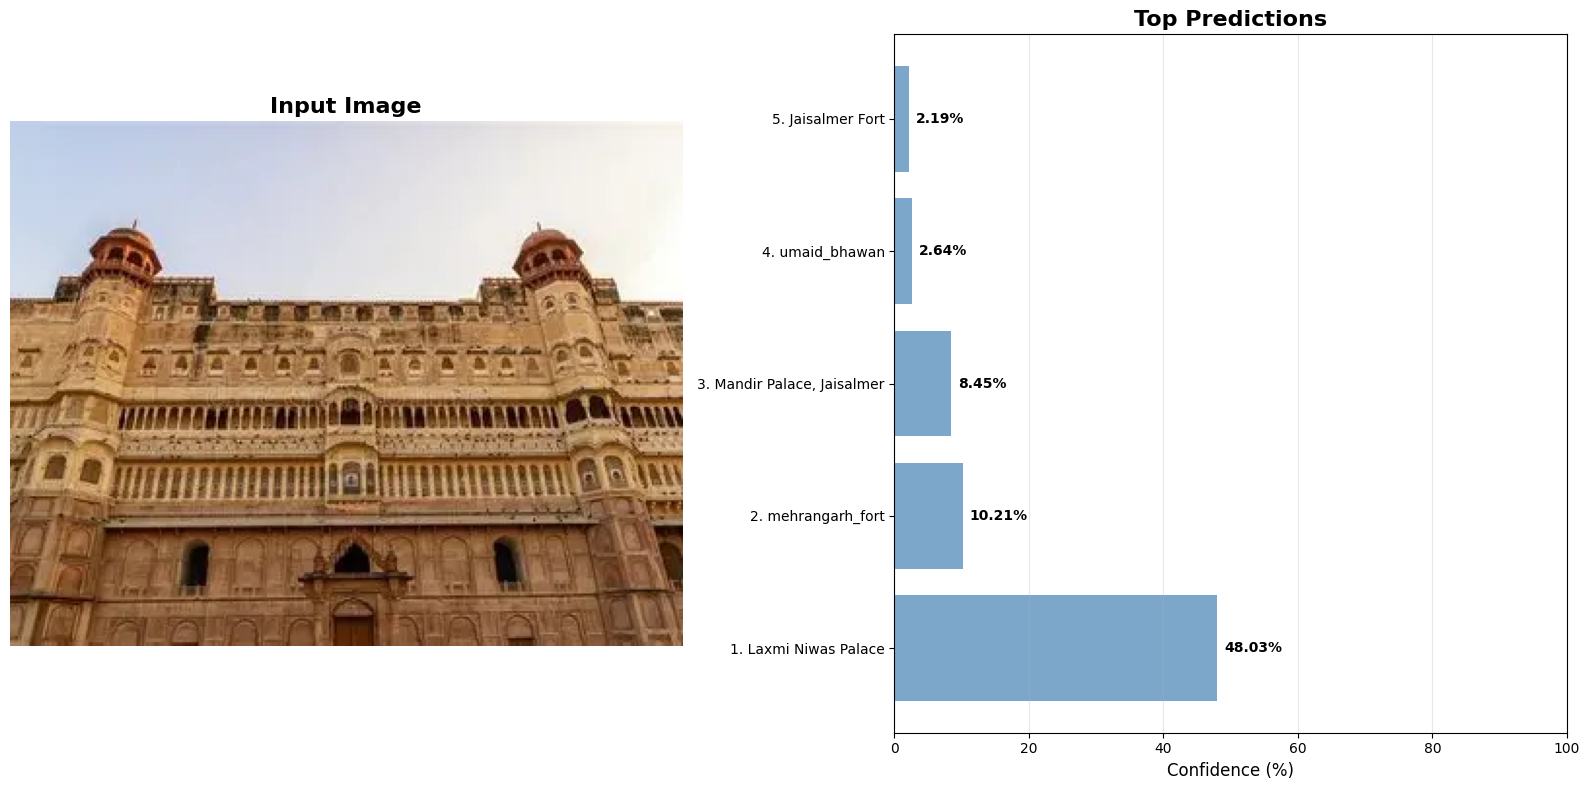


PREDICTION RESULTS
🎯 Top Prediction: Laxmi Niwas Palace
   Confidence: 48.03%

📊 Top 5 Predictions:
   1. Laxmi Niwas Palace: 48.03%
   2. mehrangarh_fort: 10.21%
   3. Mandir Palace, Jaisalmer: 8.45%
   4. umaid_bhawan: 2.64%
   5. Jaisalmer Fort: 2.19%


In [ ]:

import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import os
import random
from google.colab import files
from google.colab.patches import cv2_imshow
import requests
from io import BytesIO

class VisionTransformerModel(torch.nn.Module):
    def __init__(self, num_classes, model_name='vit_base_patch16_224', pretrained=True, dropout=0.3):
        super().__init__()
        import timm
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
        )
        feature_dim = self.model.num_features
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        features = self.model(x)
        features = self.dropout(features)
        return self.classifier(features)

def get_transforms(image_size=224):
    """Get image preprocessing transforms"""
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

def load_model(model_path='/content/best_landmark_model.pth', device='cuda'):
    """Load the trained model"""
    print(f"Loading model from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device)

    # Get class mappings
    if 'class_to_idx' in checkpoint:
        class_to_idx = checkpoint['class_to_idx']
        idx_to_class = {v: k for k, v in class_to_idx.items()}
    elif 'idx_to_class' in checkpoint:
        idx_to_class = checkpoint['idx_to_class']
        class_to_idx = {v: k for k, v in idx_to_class.items()}
    else:
        raise ValueError("Checkpoint missing class mappings!")

    num_classes = len(idx_to_class)

    # Get model config
    config = checkpoint.get('config', {})
    model_name = config.get('model_name', 'vit_base_patch16_224')
    dropout = config.get('dropout', 0.3)

    # Create and load model
    model = VisionTransformerModel(
        num_classes=num_classes,
        model_name=model_name,
        pretrained=False,
        dropout=dropout
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"✅ Model loaded successfully!")
    print(f"   Classes: {num_classes}")
    print(f"   Device: {device}")

    return model, idx_to_class, class_to_idx

def predict_image(model, image_path_or_array, idx_to_class, device='cuda', top_k=5):
    """Predict landmarks in an image"""
    # Load image
    if isinstance(image_path_or_array, str):
        if image_path_or_array.startswith('http'):
            # Load from URL
            response = requests.get(image_path_or_array)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            # Load from file path
            image = Image.open(image_path_or_array).convert('RGB')
    else:
        # Already a PIL Image or numpy array
        if isinstance(image_path_or_array, np.ndarray):
            image = Image.fromarray(image_path_or_array).convert('RGB')
        else:
            image = image_path_or_array.convert('RGB')

    # Preprocess
    transform = get_transforms()
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probabilities, min(top_k, len(idx_to_class)))

    # Get predictions
    predictions = []
    for prob, idx in zip(top_probs[0], top_indices[0]):
        predictions.append({
            'landmark': idx_to_class[idx.item()],
            'confidence': prob.item()
        })

    return image, predictions

def visualize_predictions(image, predictions, save_path=None):
    """Visualize predictions with the image"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Show image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title('Input Image', fontsize=16, fontweight='bold')

    # Show predictions
    landmarks = [p['landmark'] for p in predictions]
    confidences = [p['confidence'] * 100 for p in predictions]

    # Create horizontal bar chart
    y_pos = np.arange(len(landmarks))
    axes[1].barh(y_pos, confidences, color='steelblue', alpha=0.7)
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels([f"{i+1}. {landmark}" for i, landmark in enumerate(landmarks)])
    axes[1].set_xlabel('Confidence (%)', fontsize=12)
    axes[1].set_title('Top Predictions', fontsize=16, fontweight='bold')
    axes[1].set_xlim(0, 100)
    axes[1].grid(axis='x', alpha=0.3)

    # Add confidence values on bars
    for i, conf in enumerate(confidences):
        axes[1].text(conf + 1, i, f'{conf:.2f}%',
                    va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✅ Visualization saved to {save_path}")

    plt.show()

    # Print predictions
    print("\n" + "="*60)
    print("PREDICTION RESULTS")
    print("="*60)
    print(f"🎯 Top Prediction: {predictions[0]['landmark']}")
    print(f"   Confidence: {predictions[0]['confidence']*100:.2f}%")
    print("\n📊 Top 5 Predictions:")
    for i, pred in enumerate(predictions, 1):
        print(f"   {i}. {pred['landmark']}: {pred['confidence']*100:.2f}%")
    print("="*60)

def test_from_upload(model, idx_to_class, device='cuda'):
    """Test model with uploaded image"""
    print("\n📤 Upload an image to test...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded!")
        return

    image_path = list(uploaded.keys())[0]
    print(f"✅ Image uploaded: {image_path}")

    image, predictions = predict_image(model, image_path, idx_to_class, device)
    visualize_predictions(image, predictions)

def test_from_test_set(model, idx_to_class, class_to_idx, device='cuda', data_root=None):
    """Test model with random image from test set"""
    if data_root is None:
        data_root = '/content/drive/MyDrive/AI_LANDMARK_AND_SCENE_DETECTION/Rajasthan_Landmark_dataset/Rajasthan_Landmark_dataset'

    if not os.path.exists(data_root):
        print(f"❌ Dataset not found at {data_root}")
        print("Please update data_root or use test_from_upload()")
        return

    # Get all images
    all_images = []
    for city in os.listdir(data_root):
        city_path = os.path.join(data_root, city)
        if not os.path.isdir(city_path):
            continue
        for landmark in os.listdir(city_path):
            landmark_path = os.path.join(city_path, landmark)
            if not os.path.isdir(landmark_path):
                continue
            for filename in os.listdir(landmark_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG', '.webp')):
                    image_path = os.path.join(landmark_path, filename)
                    # Get true label
                    if landmark in class_to_idx:
                        all_images.append((image_path, landmark, class_to_idx[landmark]))

    if not all_images:
        print("❌ No images found in dataset!")
        return

    # Pick random image
    image_path, true_landmark, true_label = random.choice(all_images)
    print(f"\n🎲 Random image selected:")
    print(f"   Path: {image_path}")
    print(f"   True Label: {true_landmark}")

    image, predictions = predict_image(model, image_path, idx_to_class, device)

    # Check if prediction is correct
    predicted_landmark = predictions[0]['landmark']
    is_correct = predicted_landmark == true_landmark

    visualize_predictions(image, predictions)

    print(f"\n{'✅ CORRECT!' if is_correct else '❌ INCORRECT'}")
    print(f"True label: {true_landmark}")
    print(f"Predicted: {predicted_landmark}")

def test_from_url(model, idx_to_class, device='cuda', image_url=None):
    """Test model with image from URL"""
    if image_url is None:
        image_url = input("Enter image URL: ")

    print(f"🔄 Loading image from URL...")
    try:
        image, predictions = predict_image(model, image_url, idx_to_class, device)
        visualize_predictions(image, predictions)
    except Exception as e:
        print(f"❌ Error loading image: {e}")

# ============================================
# MAIN EXECUTION
# ============================================

def main():
    """Main testing function"""
    print("="*60)
    print("LANDMARK DETECTION - MODEL TESTING")
    print("="*60)

    # Set device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")

    # Load model
    model_path = '/content/drive/MyDrive/best_landmark_model.pth'
    if not os.path.exists(model_path):
        # Try Google Drive
        model_path = '/content/drive/MyDrive/best_landmark_model.pth'
        if not os.path.exists(model_path):
            print("❌ Model not found! Please check the path.")
            return

    model, idx_to_class, class_to_idx = load_model(model_path, device)

    # Test menu
    print("\n" + "="*60)
    print("TESTING OPTIONS")
    print("="*60)
    print("1. Upload image from computer")
    print("2. Test random image from dataset")
    print("3. Test image from URL")
    print("4. Test multiple random images")
    print("="*60)

    choice = input("\nEnter choice (1-4): ").strip()

    if choice == '1':
        test_from_upload(model, idx_to_class, device)
    elif choice == '2':
        data_root = input("Enter dataset path (or press Enter for default): ").strip()
        if not data_root:
            data_root = None
        test_from_test_set(model, idx_to_class, class_to_idx, device, data_root)
    elif choice == '3':
        test_from_url(model, idx_to_class, device)
    elif choice == '4':
        num_tests = int(input("How many random images to test? "))
        data_root = input("Enter dataset path (or press Enter for default): ").strip()
        if not data_root:
            data_root = None
        for i in range(num_tests):
            print(f"\n{'='*60}")
            print(f"TEST {i+1}/{num_tests}")
            print('='*60)
            test_from_test_set(model, idx_to_class, class_to_idx, device, data_root)
    else:
        print("Invalid choice!")

if __name__ == '__main__':
    main()

In [ ]:
# ============================================
# test_hybrid_vit_model_colab.py
# For testing your trained HybridViTModel in Google Colab
# ============================================

import torch
import torch.nn.functional as F
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os, random, requests, json
from io import BytesIO
from google.colab import files

# ============================================
# HYBRID MODEL DEFINITION (same as training)
# ============================================
class HybridViTModel(torch.nn.Module):
    def __init__(self, num_classes, pretrained=False, dropout=0.4):
        super().__init__()
        # CNN backbone (ResNet50)
        self.cnn_backbone = timm.create_model('resnet50', pretrained=pretrained, features_only=True)
        cnn_channels = self.cnn_backbone.feature_info[-1]['num_chs']  # 2048

        # ViT (Base)
        self.vit_head = timm.create_model(
            'vit_base_patch16_224',
            pretrained=pretrained,
            num_classes=0
        )

        # Projection + Fusion
        self.proj = torch.nn.Conv2d(cnn_channels, 768, kernel_size=1)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(1536, num_classes)

    def forward(self, x):
        # CNN branch (fine detail)
        cnn_feats = self.cnn_backbone(x)[-1]       # [B, 2048, 7, 7]
        proj_feats = self.proj(cnn_feats)          # [B, 768, 7, 7]
        cnn_global = proj_feats.mean(dim=[2, 3])   # [B, 768]

        # ViT branch (context)
        vit_out = self.vit_head.forward_features(x)
        if vit_out.dim() == 3:
            vit_global = vit_out[:, 0, :]          # CLS token
        else:
            vit_global = vit_out                   # [B, 768]

        # Fuse + classify
        fused = torch.cat((vit_global, cnn_global), dim=1)  # [B, 1536]
        out = self.dropout(fused)
        logits = self.fc(out)
        return logits

# ============================================
# IMAGE TRANSFORMS
# ============================================
def get_transforms(size=224):
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

# ============================================
# LOAD TRAINED MODEL
# ============================================
def load_model(model_path='/content/drive/MyDrive/best_hybrid_landmark_model.pth', device='cuda'):
    print(f"🔄 Loading model from {model_path}...")
    checkpoint = torch.load(model_path, map_location=device)

    class_map = checkpoint['class_map']
    idx_map = checkpoint['idx_map']
    num_classes = len(class_map)
    config = checkpoint.get('config', {})
    dropout = config.get('dropout', 0.4)

    model = HybridViTModel(num_classes=num_classes, pretrained=False, dropout=dropout).to(device)
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    model.eval()

    print(f"✅ Model loaded successfully on {device}")
    print(f"Classes: {num_classes}")
    return model, idx_map, class_map

# ============================================
# PREDICTION FUNCTION
# ============================================
def predict_image(model, image_input, idx_map, device='cuda', top_k=5):
    # Handle file path or URL
    if isinstance(image_input, str):
        if image_input.startswith('http'):
            response = requests.get(image_input)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(image_input).convert('RGB')
    else:
        image = image_input.convert('RGB')

    transform = get_transforms()
    tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        probs = F.softmax(logits, dim=1)
        top_probs, top_idxs = torch.topk(probs, min(top_k, len(idx_map)))

    preds = [
        {'landmark': idx_map[i.item()], 'confidence': p.item()}
        for p, i in zip(top_probs[0], top_idxs[0])
    ]
    return image, preds

# ============================================
# VISUALIZATION
# ============================================
def visualize_predictions(image, preds, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Show image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title("Input Image", fontsize=16, fontweight='bold')

    # Predictions
    labels = [p['landmark'] for p in preds]
    confs = [p['confidence'] * 100 for p in preds]
    y = np.arange(len(labels))

    axes[1].barh(y, confs, color='skyblue')
    axes[1].set_yticks(y)
    axes[1].set_yticklabels(labels)
    axes[1].invert_yaxis()
    axes[1].set_xlabel("Confidence (%)")
    axes[1].set_xlim(0, 100)

    for i, c in enumerate(confs):
        axes[1].text(c + 1, i, f"{c:.2f}%", va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print("\n🎯 Top Prediction:", preds[0]['landmark'], f"({preds[0]['confidence']*100:.2f}%)")
    print("\n📊 Top 5 Predictions:")
    for i, p in enumerate(preds, 1):
        print(f"{i}. {p['landmark']}: {p['confidence']*100:.2f}%")

# ============================================
# TESTING OPTIONS
# ============================================
def test_from_upload(model, idx_map, device='cuda'):
    print("\n📤 Upload an image to test...")
    uploaded = files.upload()
    if not uploaded:
        print("❌ No file uploaded!")
        return
    path = list(uploaded.keys())[0]
    img, preds = predict_image(model, path, idx_map, device)
    visualize_predictions(img, preds)

def test_from_dataset(model, idx_map, class_map, device='cuda',
                      data_root='/content/drive/MyDrive/Rajasthan_Landmark_dataset/Rajasthan_Landmark_dataset'):
    print("\n🎲 Selecting random test image...")
    all_images = []
    for city in os.listdir(data_root):
        city_path = os.path.join(data_root, city)
        if not os.path.isdir(city_path): continue
        for landmark in os.listdir(city_path):
            landmark_path = os.path.join(city_path, landmark)
            if not os.path.isdir(landmark_path): continue
            for f in os.listdir(landmark_path):
                if f.lower().endswith(('jpg', 'jpeg', 'png', 'webp')):
                    all_images.append((os.path.join(landmark_path, f), landmark))
    if not all_images:
        print("❌ No images found in dataset!")
        return

    path, label = random.choice(all_images)
    print(f"Image Path: {path}\nTrue Label: {label}")

    img, preds = predict_image(model, path, idx_map, device)
    visualize_predictions(img, preds)

    pred_label = preds[0]['landmark']
    print(f"\n✅ Correct!" if pred_label == label else f"❌ Incorrect. Predicted: {pred_label}")

def test_from_url(model, idx_map, device='cuda'):
    url = input("Enter image URL: ").strip()
    if not url:
        print("❌ No URL provided!")
        return
    img, preds = predict_image(model, url, idx_map, device)
    visualize_predictions(img, preds)

# ============================================
# MAIN EXECUTION
# ============================================
def main():
    print("="*60)
    print("HYBRID LANDMARK DETECTION - MODEL TESTING")
    print("="*60)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_path = '/content/drive/MyDrive/best_hybrid_landmark_model.pth'
    if not os.path.exists(model_path):
        model_path = '/content/drive/MyDrive/best_hybrid_landmark_model.pth'
        if not os.path.exists(model_path):
            print("❌ Model not found! Check path.")
            return

    model, idx_map, class_map = load_model(model_path, device)

    print("\nTESTING OPTIONS")
    print("="*60)
    print("1️⃣ Upload an image")
    print("2️⃣ Test random dataset image")
    print("3️⃣ Test from URL")
    print("="*60)
    choice = input("Enter choice (1/2/3): ").strip()

    if choice == '1':
        test_from_upload(model, idx_map, device)
    elif choice == '2':
        test_from_dataset(model, idx_map, class_map, device)
    elif choice == '3':
        test_from_url(model, idx_map, device)
    else:
        print("Invalid choice!")

if __name__ == "__main__":
    main()


HYBRID LANDMARK DETECTION - MODEL TESTING
🔄 Loading model from /content/drive/MyDrive/best_hybrid_landmark_model.pth...
✅ Model loaded successfully on cuda
Classes: 49

TESTING OPTIONS
1️⃣ Upload an image
2️⃣ Test random dataset image
3️⃣ Test from URL

📤 Upload an image to test...
